In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')


## 1. 데이터 불러오기

In [65]:
import pandas as pd

x = pd.read_csv('X.csv', encoding='euc-kr')
y = pd.read_csv('y.csv', encoding='euc-kr')

## 2. 데이터 전처리
---
[다음을 수행하세요]
 #### (1) 명목형 변수와 같은 성별(0/1) 예측이므로, 분류(Classifier)를 위해 준비.

 #### (2) 단순히 1부터의 숫자를 부여한 'cust_id'를 수치형 변수로 받아들이면, 결과가 왜곡될 수 있으니 지워야 함.

 #### (3) 데이터셋 구성하기 (비율은 자유롭게 설정)

 #### (4) 결측치를 평균/0 등의 값으로 대체, 결측치가 많거나 결과에 영향을 미치지 않을 것이라 판단한다면 그 column 자체를 삭제 등으로 처리.

 #### (5) 문자형 변수를 숫자형 변수로 변환하기 위해 LabelEncoder를 사용 (LabelEncoder는 문자형 변수들을 0부터 차례대로 숫자를 부여함)

##### ** 주의사항: Label Encoding할 때, Train set과 Test set에 들어있는 값이 다를 수도 있으니 binding 후 Label encoding을 한 후 다시 나눠야 제대로 된 labeling이 된다고 할 수 있다


In [66]:
data = x[:]
data['성별'] = y['gender']

In [67]:
data.drop('cust_id', axis=1)

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,성별
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16,1
4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0
...,...,...,...,...,...,...,...,...,...,...
3495,3175200,3042900,NaN,골프,본 점,1,2.000000,1.000000,0,1
3496,29628600,7200000,6049600.0,시티웨어,부산본점,8,1.625000,0.461538,40,1
3497,75000,75000,NaN,주방용품,창원점,1,1.000000,0.000000,0,0
3498,1875000,1000000,NaN,화장품,본 점,2,1.000000,0.000000,39,0


In [68]:
# 결측치 채우기

data.fillna(0, inplace=True)

In [69]:
data.isnull().sum()

cust_id    0
총구매액       0
최대구매액      0
환불금액       0
주구매상품      0
주구매지점      0
내점일수       0
내점당구매건수    0
주말방문비율     0
구매주기       0
성별         0
dtype: int64

In [70]:
data['주구매상품'].value_counts()

주구매상품
기타        595
가공식품      546
농산물       339
화장품       264
시티웨어      213
디자이너      193
수산품       153
캐주얼       101
명품        100
섬유잡화       98
골프         82
스포츠        69
일용잡화       64
모피/피혁      57
육류         57
남성 캐주얼     55
구두         54
건강식품       47
차/커피       44
피혁잡화       40
아동         40
축산가공       35
주방용품       32
셔츠         30
젓갈/반찬      29
주방가전       26
트래디셔널      23
남성정장       22
생활잡화       15
주류         14
가구         10
커리어         9
대형가전        8
란제리/내의      8
식기          7
액세서리        5
침구/수예       4
통신/컴퓨터      3
보석          3
남성 트랜디      2
소형가전        2
악기          2
Name: count, dtype: int64

In [71]:
data['주구매지점'].value_counts().count()

24

In [72]:
# 문자형 변수 label encoding

encoder = LabelEncoder()
data['주구매지점'] = encoder.fit_transform(data['주구매지점'])
data['주구매상품'] = encoder.fit_transform(data['주구매상품'])

In [73]:
data.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,성별
0,0,68282840,11264000,6860000.0,5,0,19,3.894737,0.527027,17,0
1,1,2136000,2136000,300000.0,21,19,2,1.500000,0.000000,1,0
2,2,3197000,1639000,0.0,6,1,2,2.000000,0.000000,1,1
3,3,16077620,4935000,0.0,5,2,18,2.444444,0.318182,16,1
4,4,29050000,24000000,0.0,15,8,2,1.500000,0.000000,85,0


## 3.  모델 선택 ( Decision Tree 로 구현 )

In [74]:
# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=1027)

# 학습과 테스트 데이터 셋으로 분리
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, test_size=0.2, random_state=1027, stratify=y)

# DecisionTreeClassifer 학습. 
dt_clf.fit(x_trn , y_trn)

DecisionTreeClassifier(random_state=1027)

In [107]:
parameters = {'max_depth':[1,2,3,4], 'min_samples_split':[1,2,3,4,5,10], 'max_features':[1,2,3,5,9]}
grid_dt = GridSearchCV(dt_clf, param_grid=parameters, cv=3, refit=True)

grid_dt.fit(x_trn, y_trn)

scores_df = pd.DataFrame(grid_dt.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",NaN,101,NaN,NaN,NaN
1,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.623928,46,0.624197,0.623794,0.623794
2,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.623928,46,0.624197,0.623794,0.623794
3,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.623928,46,0.624197,0.623794,0.623794
4,"{'max_depth': 1, 'max_features': 1, 'min_sampl...",0.623928,46,0.624197,0.623794,0.623794
...,...,...,...,...,...,...
115,"{'max_depth': 4, 'max_features': 9, 'min_sampl...",0.618568,76,0.627409,0.615220,0.613076
116,"{'max_depth': 4, 'max_features': 9, 'min_sampl...",0.618568,76,0.627409,0.615220,0.613076
117,"{'max_depth': 4, 'max_features': 9, 'min_sampl...",0.618568,76,0.627409,0.615220,0.613076
118,"{'max_depth': 4, 'max_features': 9, 'min_sampl...",0.618568,76,0.627409,0.615220,0.613076


In [108]:
print('GridSearchCV 최적 파라미터:', grid_dt.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dt.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': 3, 'max_features': 2, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.6386


In [58]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함. 
export_graphviz(dt_clf, out_file="tree.dot", class_names=['female', 'male'] , \
feature_names = data.columns[:-1], impurity=True, filled=True)

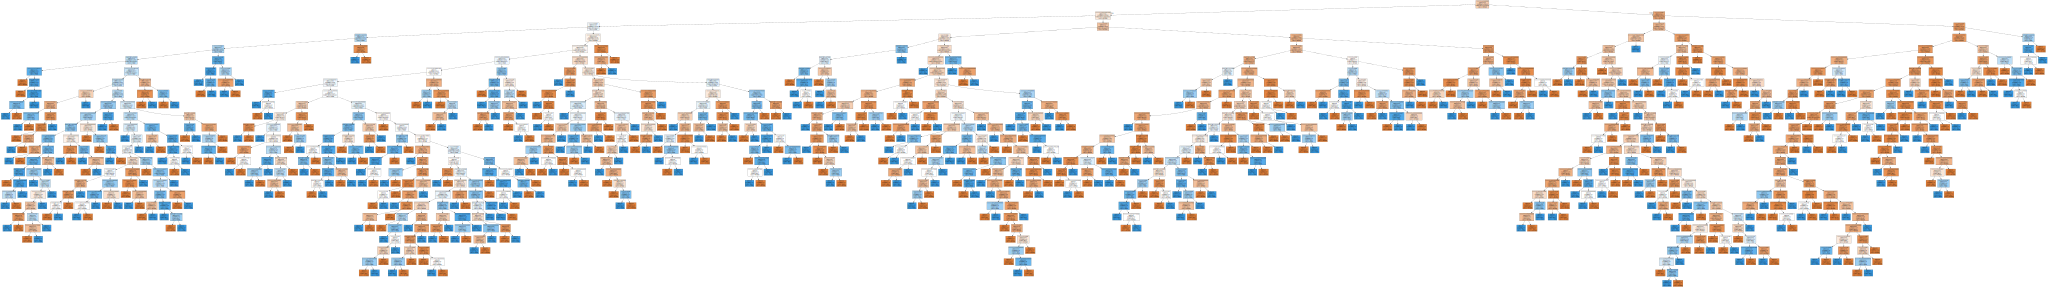

In [59]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## 4. 예측 결과 확인 ( ROC-AUC 평가지표 사용 )

In [77]:
pred = dt_clf.predict(x_tst)

In [109]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
estimator = grid_dt.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = estimator.predict(x_tst)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_tst, pred)))

테스트 데이터 세트 정확도: 0.6457


In [116]:
pred_proba = estimator.predict_proba(x_tst)

In [117]:
pred_proba

array([[0.82719547, 0.17280453],
       [0.82719547, 0.17280453],
       [0.67042254, 0.32957746],
       ...,
       [0.82719547, 0.17280453],
       [0.4491654 , 0.5508346 ],
       [0.4491654 , 0.5508346 ]])

In [115]:
print("정확도:", accuracy_score(y_tst, pred))
print("정밀도:", precision_score(y_tst, pred))
print("재현율:", recall_score(y_tst, pred))
print("F1 Score:", f1_score(y_tst, pred))

정확도: 0.6457142857142857
정밀도: 0.5433526011560693
재현율: 0.3574144486692015
F1 Score: 0.43119266055045874


In [118]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 =  estimator.predict_proba(x_tst)[:, 1]

fprs , tprs , thresholds = roc_curve(y_tst, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [1 6]
샘플 index로 추출한 임곗값:  [0.63 0.29]
샘플 임곗값별 FPR:  [0.005 0.693]
샘플 임곗값별 TPR:  [0.015 0.859]


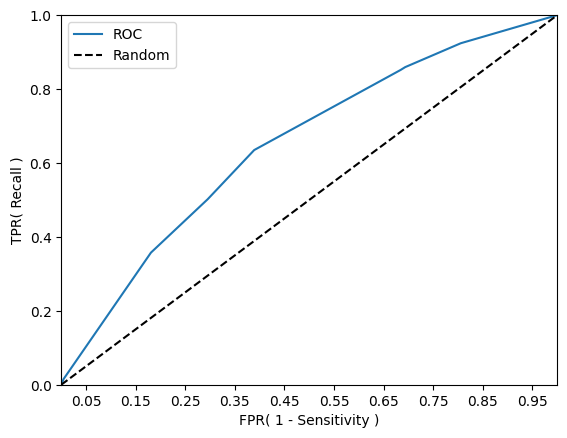

In [120]:
def roc_curve_plot(y_tst , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_tst ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_tst, estimator.predict_proba(x_tst)[:, 1] )

In [121]:
from sklearn.metrics import roc_auc_score

### 아래는 roc_auc_score()의 인자를 잘못 입력한 것으로, 책에서 수정이 필요한 부분입니다. 
### 책에서는 roc_auc_score(y_test, pred)로 예측 타겟값을 입력하였으나 
### roc_auc_score(y_test, y_score)로 y_score는 predict_proba()로 호출된 예측 확률 ndarray중 Positive 열에 해당하는 ndarray입니다. 

#pred = lr_clf.predict(X_test)
#roc_score = roc_auc_score(y_test, pred)

pred_proba = estimator.predict_proba(x_tst)[:, 1]
roc_score = roc_auc_score(y_tst, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.6497
